<a href="https://colab.research.google.com/github/el-geuse/EE992/blob/main/base-project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning / fine-tuning

This Lab will guide you through the process of using _transfer learning_ to learn an accurate image classifier from a relatively small number of training samples. Generally speaking, transfer learning refers to the process of leveraging the knowledge learned in one model for the training of another model.

More specifically, the process involves taking an existing neural network which was previously trained to good performance on a larger dataset, and using it as the basis for a new model which leverages that previous network's accuracy for a new task. This method has become popular in recent years to improve the performance of a neural net trained on a small dataset; the intuition is that the new dataset may be too small to train to good performance by itself, but we know that most neural nets trained to learn image features often learn similar features anyway, especially at early layers where they are more generic (edge detectors, blobs, and so on).

Transfer learning has been largely enabled by the open-sourcing of state-of-the-art models; for the top performing models in image classification tasks (like from [ILSVRC](http://www.image-net.org/challenges/LSVRC/)), it is common practice now to not only publish the architecture, but to release the trained weights of the model as well. This lets amateurs use these top image classifiers to boost the performance of their own task-specific models.

#### Feature extraction vs. fine-tuning

At one extreme, transfer learning can involve taking the pre-trained network and freezing the weights, and using one of its hidden layers (usually the last one) as a feature extractor, using those features as the input to a smaller neural net.

At the other extreme, we start with the pre-trained network, but we allow some of the weights (usually the last layer or last few layers) to be modified. Another name for this procedure is called "fine-tuning" because we are slightly adjusting the pre-trained net's weights to the new task. We usually train such a network with a lower learning rate, since we expect the features are already relatively good and do not need to be changed too much.

Sometimes, we do something in-between: Freeze just the early/generic layers, but fine-tune the later layers. Which strategy is best depends on the size of your dataset, the number of classes, and how much it resembles the dataset the previous model was trained on (and thus, whether it can benefit from the same learned feature extractors). A more detailed discussion of how to strategize can be found in [[1]](http://cs231n.github.io/transfer-learning/) [[2]](http://sebastianruder.com/transfer-learning/).

## Procedure

In this guide will go through the process of loading a state-of-the-art, 1000-class image classifier, [VGG16](https://arxiv.org/pdf/1409.1556.pdf) which [won the ImageNet challenge in 2014](http://www.robots.ox.ac.uk/~vgg/research/very_deep/), and using it as a fixed feature extractor to train a smaller custom classifier on our own images, although with very few code changes, you can try fine-tuning as well.

##Introduction to Transfer Learning with Keras and VGG16
In this lab, we will demonstrate how to use transfer learning to train a deep learning model for image classification. Transfer learning is a powerful technique for training deep neural networks on large datasets where the data is limited. This is achieved by using pre-trained models, such as VGG16, as a starting point and then fine-tuning the model to the specific task we are interested in.

For this tutorial, we will use the CIFAR10 dataset, which contains 60,000 32x32 color training images and 10,000 test images, with 10 classes. The classes are completely mutually exclusive and there is no overlap between them.

We will use the VGG16 model, which is a pre-trained deep neural network on the ImageNet dataset. We will fine-tune this model on the CIFAR10 dataset to perform image classification.


#Load Dependencies
We start by loading the necessary dependencies, which are TensorFlow and Keras. We also import the VGG16 model from the keras.applications module.

In [ ]:
%matplotlib inline


!cat /proc/cpuinfo # gives details of CPU

!nvidia-smi # gives details of GPU

# !pip uninstall tensorflow  #just incase you want to change version
# !pip install tensorflow==2.X.0
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Model


# Commonly used modules
import numpy as np
import os, datetime
import sys

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import IPython
from six.moves import urllib

print(tf.__version__)


from matplotlib.pyplot import imshow


processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
stepping	: 3
microcode	: 0xffffffff
cpu MHz		: 2000.150
cache size	: 39424 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmi

#Load the CIFAR10 Dataset
Next, we load the CIFAR10 dataset using the keras.datasets.cifar10.load_data function. This will return two tuples, one for the training data and one for the test data.

In [ ]:
# (images_train, labels_train), (images_test, labels_test) = keras.datasets.cifar10.load_data()

from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test)  = cifar10.load_data()

# return the modified images
print("Train Images shape: ",x_train.shape)
print("Test Images shape: ",x_test.shape)
print(y_train.shape)
print(y_test.shape)


170498071/170498071 [==============================] - 14s 0us/step
Train Images shape:  (50000, 32, 32, 3)
Test Images shape:  (10000, 32, 32, 3)
(50000, 1)
(10000, 1)


#Preprocess the Data
Before we start using the data, we need to preprocess it. In this case, we convert the data to float32 and scale it by dividing it by 255.

In [ ]:
def preprocess_images(X, Y): # should work for both a single image and multiple images
    X_p = keras.applications.densenet.preprocess_input(X)
    Y_p = keras.utils.to_categorical(Y, 10)
    return X_p, Y_p

# preprocess the train images
x_train, y_train = preprocess_images(x_train, y_train)

# preprocess the test images
x_test, y_test = preprocess_images(x_test, y_test)

#Print some examples of the data

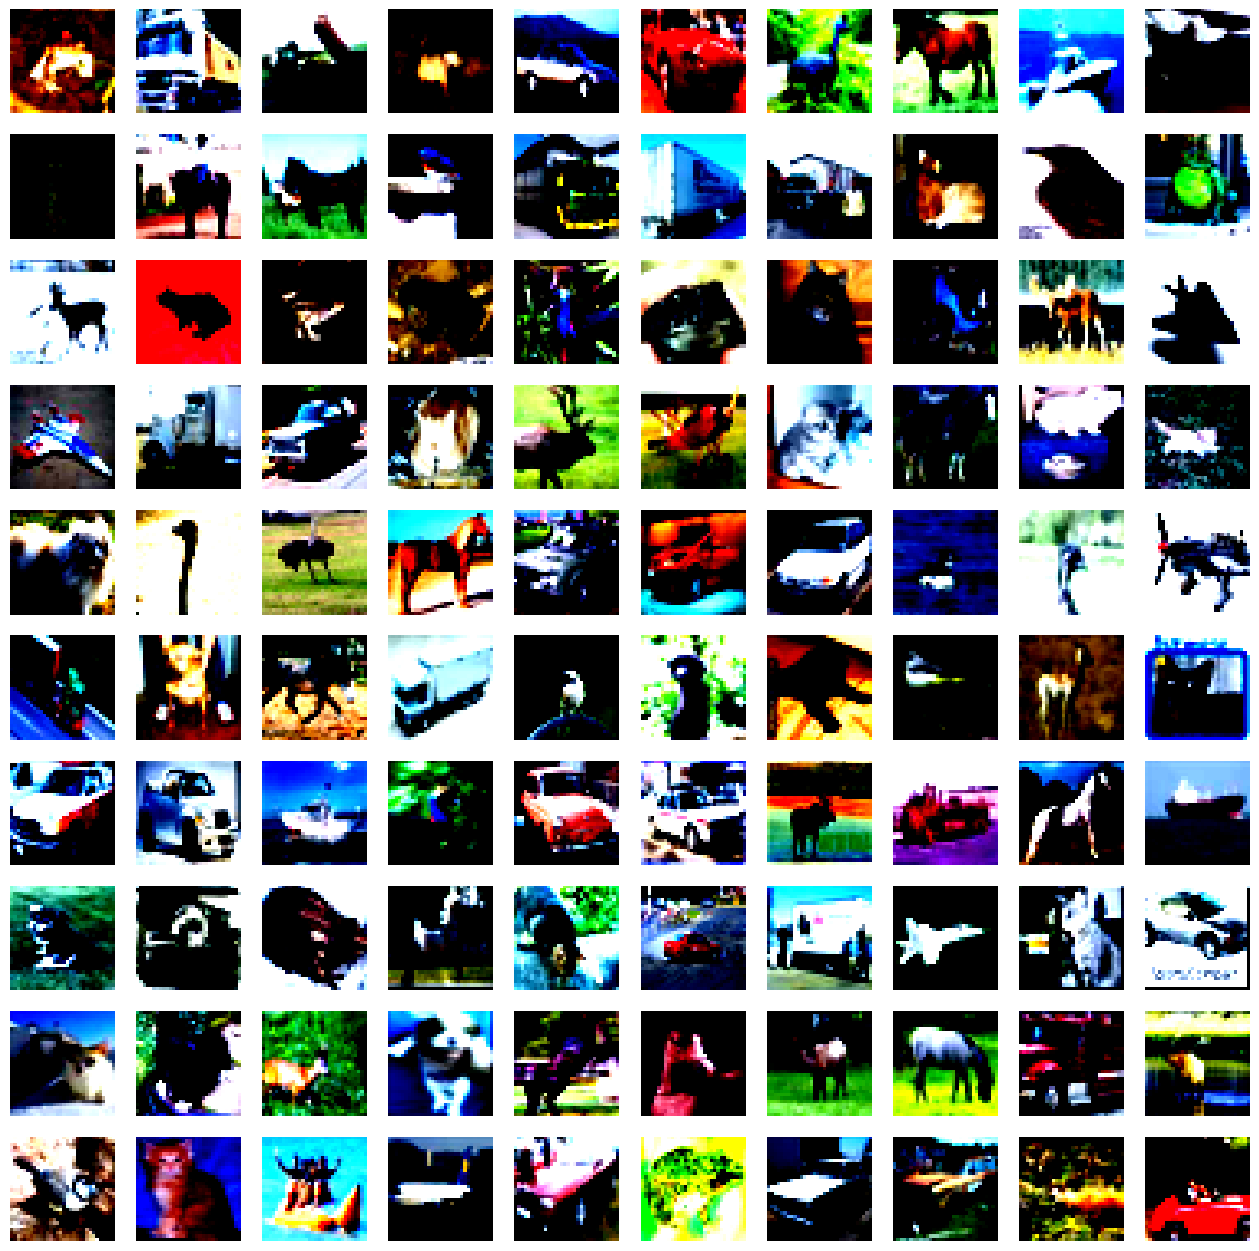

In [ ]:
plt.figure(figsize = (16,16))
for i in range(100):
  plt.subplot(10,10,1+i)
  plt.axis('off')
  plt.imshow(x_train[i], cmap = 'gray')
  # plt.xlabel(y_train[i])

### First training a neural net from scratch

Before doing the transfer learning, let's first build a neural network from scratch for doing classification on our dataset. This will give us a baseline to compare to our transfer-learned network later.

Lets use the CNN we built in the last lab to test on this new challange.


In [ ]:
# # create a sequential model
# model = keras.Sequential()

# # add a 2D convolution layer with 32 filters of size 3x3 and relu activation
# model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
# # add a 2D convolution layer with 64 filters of size 3x3 and relu activation
# model.add(Conv2D(128, (3, 3), activation='relu'))
# # add a 2D pooling layer to choose the best features via pooling
# model.add(MaxPooling2D(pool_size=(2, 2)))
# # add a dropout layer to randomly turn neurons on and off to improve convergence
# model.add(Dropout(0.25))
# # flatten the data since too many dimensions, we only want a classification output
# model.add(Flatten())
# # add a fully connected layer with 128 neurons and relu activation
# model.add(Dense(256, activation='relu'))
# # add a dropout layer to randomly turn neurons on and off to improve convergence
# model.add(Dropout(0.5))
# # add a final output layer with 10 neurons and softmax activation
# model.add(Dense(10, activation='softmax'))

# # print the summary of the model
# model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 128)       0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                        

In [ ]:
# # Compiling the model using sparse_categorical_crossentropy as the loss function,
# # the Adam optimizer with a learning rate of 0.001 and accuracy as the metric to track.
# model.compile(loss='sparse_categorical_crossentropy',
#               optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#               metrics=['accuracy'])

# # Fitting the model to the training data, using a batch size of 128 and 15 epochs.
# # Also, validation data is passed as (images_test, labels_test) to calculate validation loss and accuracy.
# history = model.fit(x_train, y_train,
#                     batch_size=128,
#                     epochs=15,
#                     validation_data=(x_test, y_test))

# # Create a DataFrame from the history of the training and store the epoch values.
# hist = pd.DataFrame(history.history)
# hist['epoch'] = history.epoch

# # Finally, display the hist DataFrame.
# hist



Epoch 1/15


KeyboardInterrupt: 

Let's plot the validation loss and validation accuracy over time.

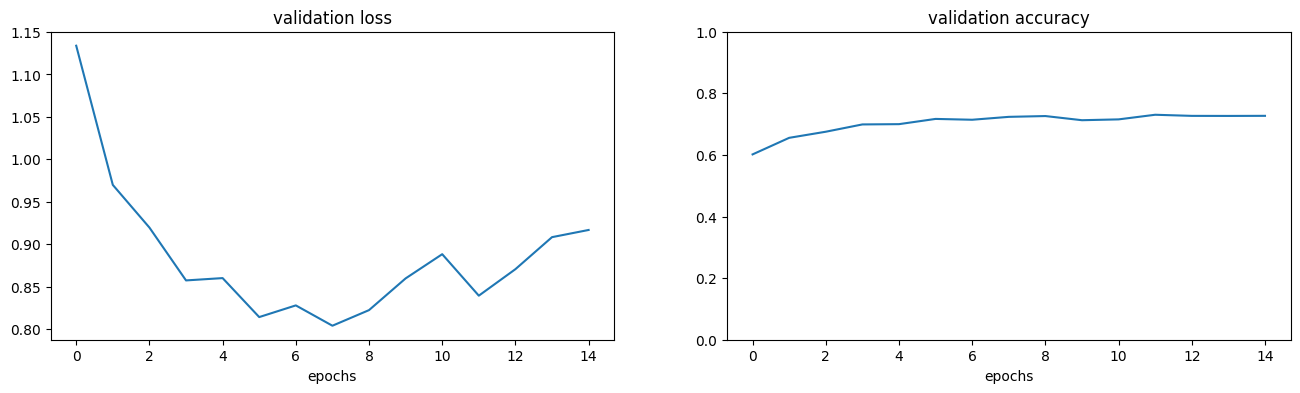

In [ ]:

# fig = plt.figure(figsize=(16,4))
# ax = fig.add_subplot(121)
# ax.plot(history.history["val_loss"])
# ax.set_title("validation loss")
# ax.set_xlabel("epochs")

# ax2 = fig.add_subplot(122)
# ax2.plot(history.history["val_accuracy"])
# ax2.set_title("validation accuracy")
# ax2.set_xlabel("epochs")
# ax2.set_ylim(0, 1)

# plt.show()

# Transfer learning by starting with existing network

Now we can move on to the main strategy for training an image classifier on our small dataset: by starting with a larger and already trained network.

To start, we will load the VGG16 from keras, which was trained on ImageNet and the weights saved online. If this is your first time loading VGG16, you'll need to wait a bit for the weights to download from the web. Once the network is loaded, we can again inspect the layers with the `summary()` method.

#Load the VGG16 Model
Next, we load the VGG16 model using the VGG16 function from the keras.applications module. We set the weights argument to 'imagenet' to indicate that we want to use the ImageNet pre-trained weights. We set include_top to False to indicate that we do not want to include the fully connected layers at the top of the network, as we will add our own fully connected layer for classification. Finally, we set the input_shape to (32, 32, 3) to match the shape of the CIFAR10 data.

In this code, we are first importing the VGG16 model from the keras.applications module. Then, we are instantiating the VGG16 model by calling VGG16(). The weights argument is set to 'imagenet', which means the model will be loaded with pre-trained weights on the ImageNet dataset.

The include_top argument is set to False, which means that the fully connected layers at the top of the network will not be included. This is often done when using pre-trained models as a feature extractor, since the top layers are typically task-specific and not transferable to other tasks.

Finally, the input_shape argument is set to (32, 32, 3), which specifies the shape of the input images. In this case, the images are 32x32 pixels with 3 color channels (red, green, and blue).

The vgg16.summary() line is used to print a summary of the model architecture, including the number of layers, number of parameters, and output shapes. This can be useful to get an overview of the model architecture and identify potential issues with the input shape or number of parameters.

In [ ]:
# # Import the VGG16 model from the Keras Applications module
# from keras.applications.vgg16 import VGG16

# # Instantiating the VGG16 model with pre-trained weights on ImageNet dataset
# vgg16 = VGG16(weights='imagenet',
#               # exclude the fully connected layers at the top of the network
#               include_top=False,
#               # specify the input shape of the images, in this case 32x32 pixels with 3 color channels
#               input_shape=(224, 224, 3))

# # Print a summary of the model architecture
# vgg16.summary()

# input tensor
inputs = keras.Input(shape=(32, 32, 3))

# upscale layer
upscale = keras.layers.Lambda(lambda x: tf.image.resize_with_pad(x,
            160,
            160,
            method=tf.image.ResizeMethod.BILINEAR))(inputs)

# load base model
base_model = keras.applications.DenseNet121(include_top=False,
                                        weights='imagenet',
                                        input_tensor=upscale,
                                        input_shape=(160,160,3),
                                        pooling='max')

base_model.summary()


Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 lambda_2 (Lambda)           (None, 160, 160, 3)          0         ['input_4[0][0]']             
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 166, 166, 3)          0         ['lambda_2[0][0]']            
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 80, 80, 64)           9408      ['zero_padding2d_2[0

Notice that VGG16 is _much_ bigger than the network we constructed earlier. It contains 13 convolutional layers and two fully connected layers at the end, and has over 138 million parameters, around 100 times as many parameters than the network we made above. Like our first network, the majority of the parameters are stored in the connections leading into the first fully-connected layer.

VGG16 was made to solve ImageNet, and achieves a [8.8% top-5 error rate](https://github.com/jcjohnson/cnn-benchmarks), which means that 91.2% of test samples were classified correctly within the top 5 predictions for each image. It's top-1 accuracy--equivalent to the accuracy metric we've been using (that the top prediction is correct)--is 73%. This is especially impressive since there are 1000 classes, meaning that random guesses would get us only 0.1% accuracy.

In order to use this network for our task, we "remove" the final classification layer, the 1000-neuron softmax layer at the end, which corresponds to ImageNet, and instead replace it with a new softmax layer for our dataset, which contains 10 neurons in the case of the 10_ObjectCategories dataset.

In terms of implementation, it's easier to simply create a copy of VGG from its input layer until the second to last layer, and then work with that, rather than modifying the VGG object directly. So technically we never "remove" anything, we just circumvent/ignore it. This can be done in the following way, by using the keras `Model` class to initialize a new model whose input layer is the same as VGG but whose output layer is our new softmax layer, called `new_classification_layer`. Note: although it appears we are duplicating this large network, internally Keras is actually just copying all the layers by reference, and thus we don't need to worry about overloading the memory.

In [ ]:

# # Creating an input layer with shape (32, 32, 3) which represents the shape of the input image
# inputs = Input(shape=(224, 224, 3))

# # Applying the VGG16 model to the inputs and storing the output in the variable 'x'
# x = vgg16(inputs)

# # Flattening the output of the previous layer 'x'
# x = Flatten()(x)

# # Adding a dense layer with 256 neurons and 'relu' activation function
# x = Dense(100, activation='relu')(x)

# # Adding a dense layer with 256 neurons and 'relu' activation function
# x = Dense(40, activation='relu')(x)

# # Adding the final layer with 10 neurons and 'softmax' activation function for the classification of 10 classes
# predictions = Dense(10, activation='softmax')(x)

# # Creating a Model with the input layer 'inputs' and the output layer 'predictions'
# model_new = Model(inputs=inputs, outputs=predictions)


# model_new.summary()


# add top layers
out = base_model.output
out = keras.layers.Flatten()(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(256, activation='relu')(out)
out = keras.layers.Dropout(0.3)(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(128, activation='relu')(out)
out = keras.layers.Dropout(0.3)(out)
out = keras.layers.BatchNormalization()(out)
out = keras.layers.Dense(64, activation='relu')(out)
out = keras.layers.Dropout(0.3)(out)
out = keras.layers.Dense(10, activation='softmax')(out)



We are going to retrain this network, `model_new` on the new dataset and labels. But first, we need to freeze the weights and biases in all the layers in the network, except our new one at the end, with the expectation that the features that were learned in VGG should still be fairly relevant to the new image classification task. Not optimal, but most likely better than what we can train to in our limited dataset.

By setting the `trainable` flag in each layer false (except our new classification layer), we ensure all the weights and biases in those layers remain fixed, and we simply train the weights in the one layer at the end. In some cases, it is desirable to *not* freeze all the pre-classification layers. If your dataset has enough samples, and doesn't resemble ImageNet very much, it might be advantageous to fine-tune some of the VGG layers along with the new classifier, or possibly even all of them. To do this, you can change the below code to make more of the layers trainable.

In the case of Cifar-10, we will just do feature extraction, fearing that fine-tuning too much with this dataset may overfit. But maybe we are wrong? A good exercise would be to try out both, and compare the results.

So we go ahead and freeze the layers, and compile the new model with exactly the same optimizer and loss function as in our first network, for the sake of a fair comparison. We then run `summary` again to look at the network's architecture.

In [ ]:
# # make all layers untrainable by freezing weights (except for last layer)
# for l, layer in enumerate(model_new.layers[:-3]):
#     layer.trainable = False

# # ensure the last layer is trainable/not frozen
# for l, layer in enumerate(model_new.layers[-3:]):
#     layer.trainable = True

# This loop will make all layers except for the last three layers untrainable.
# This is to ensure that the pre-trained weights in the VGG16 model are not changed during training.
# The last three layers will be set to trainable so that their weights can be updated during the training process


NameError: name 'model_new' is not defined

Looking at the summary, we see the network is identical to the VGG model we instantiated earlier, except the last layer, formerly a 1000-neuron softmax, has been replaced by a new 10-neuron softmax. Additionally, we still have roughly 134 million weights, but now the vast majority of them are "non-trainable params" because we froze the layers they are contained in. We now only have 397,000 trainable parameters, which is actually only a quarter of the number of parameters needed to train the first model.

As before, we go ahead and train the new model, using the same hyperparameters (batch size and number of epochs) as before, along with the same optimization algorithm. We also keep track of its history as we go.

In [ ]:
  CALLBACKS = []
MODEL_PATH = 'cifar10.h5'

# callbacks
CALLBACKS.append(keras.callbacks.ModelCheckpoint(filepath=MODEL_PATH,
                                              monitor='val_acc',
                                              save_best_only=True))

CALLBACKS.append(keras.callbacks.EarlyStopping(monitor='val_acc',
                                            verbose=1,
                                            patience=5))

CALLBACKS.append(keras.callbacks.TensorBoard(log_dir='logs'))

model = keras.models.Model(inputs=inputs, outputs=out)

# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate = 0.001),
              metrics=['accuracy'])

# print("Train Images shape: ",images_train.shape)
# print("Test Images shape: ",images_test.shape)
# print(labels_train.shape)
# print(labels_test.shape)

model.fit(x=x_train, y=y_train,
                    batch_size=128,
                    epochs=20,
                    validation_data=(x_test, y_test),
                    callbacks=CALLBACKS)

# # Create a DataFrame from the history of the training
# hist2 = pd.DataFrame(history2.history)
# hist2['epoch'] = history2.epoch

# hist2

model.evaluate(x_test, y_test, batch_size=128, verbose=1)


Epoch 1/20
391/391 [==============================] - ETA: 0s - loss: 0.8041 - accuracy: 0.7424

391/391 [==============================] - 398s 815ms/step - loss: 0.8041 - accuracy: 0.7424 - val_loss: 0.6180 - val_accuracy: 0.8064
Epoch 2/20
391/391 [==============================] - ETA: 0s - loss: 0.3740 - accuracy: 0.8868

391/391 [==============================] - 302s 773ms/step - loss: 0.3740 - accuracy: 0.8868 - val_loss: 0.4805 - val_accuracy: 0.8462
Epoch 3/20
391/391 [==============================] - ETA: 0s - loss: 0.2812 - accuracy: 0.9138

391/391 [==============================] - 302s 772ms/step - loss: 0.2812 - accuracy: 0.9138 - val_loss: 0.4949 - val_accuracy: 0.8388
Epoch 4/20
391/391 [==============================] - ETA: 0s - loss: 0.2330 - accuracy: 0.9270

391/391 [==============================] - 301s 771ms/step - loss: 0.2330 - accuracy: 0.9270 - val_loss: 0.4245 - val_accuracy: 0.8739
Epoch 5/20
391/391 [==============================] - ETA: 0s - loss: 0.1959 - accuracy: 0.9395

391/391 [==============================] - 301s 771ms/step - loss: 0.1959 - accuracy: 0.9395 - val_loss: 0.3971 - val_accuracy: 0.8791
Epoch 6/20
391/391 [==============================] - ETA: 0s - loss: 0.1781 - accuracy: 0.9449

391/391 [==============================] - 296s 756ms/step - loss: 0.1781 - accuracy: 0.9449 - val_loss: 0.4465 - val_accuracy: 0.8722
Epoch 7/20
391/391 [==============================] - ETA: 0s - loss: 0.1595 - accuracy: 0.9509

391/391 [==============================] - 301s 769ms/step - loss: 0.1595 - accuracy: 0.9509 - val_loss: 0.3376 - val_accuracy: 0.8937
Epoch 8/20
391/391 [==============================] - ETA: 0s - loss: 0.1311 - accuracy: 0.9595

391/391 [==============================] - 301s 770ms/step - loss: 0.1311 - accuracy: 0.9595 - val_loss: 0.3614 - val_accuracy: 0.8892
Epoch 9/20
 62/391 [===>..........................] - ETA: 3:56 - loss: 0.0926 - accuracy: 0.9718

KeyboardInterrupt: 

Our validation accuracy hovers close to 60% towards the end, which is a little improvement on the original network trained from scratch.

It's worth noting also that this network actually trains _slightly faster_ than the original network, despite having more than 100 times as many parameters! This is because freezing the weights negates the need to backpropagate through all those layers, saving us on runtime.

Let's plot the validation loss and accuracy again, this time comparing the original model trained from scratch (in blue) and the new transfer-learned model in orange.

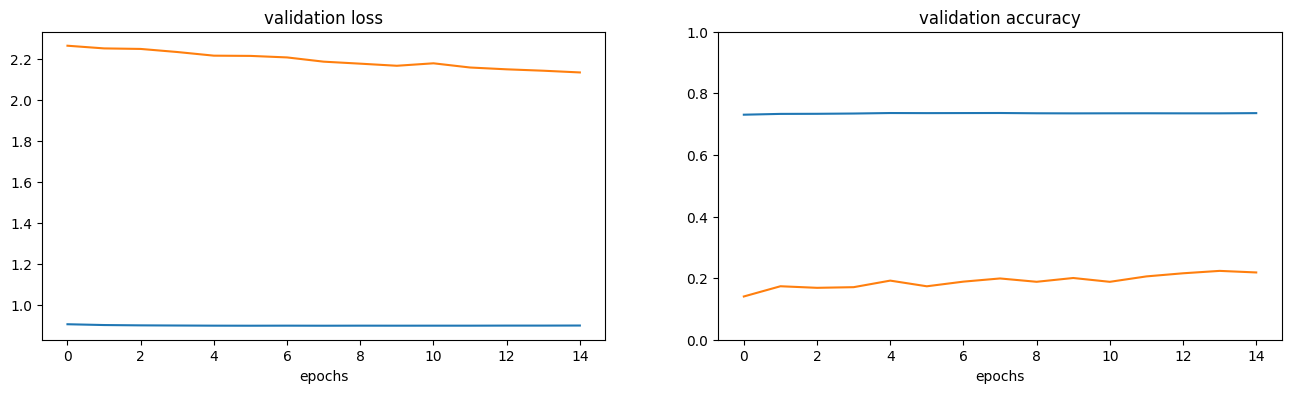

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

# Improving the results

- Using data augementation: augmentation refers to using various modifications of the original training data, in the form of distortions, rotations, rescalings, lighting changes, etc to increase the size of the training set and create more tolerance for such distortions.
- Using a different optimizer, adding more regularization/dropout, and other hyperparameters.
- Training for longer (of course)
- Try a different network, perhaps VGG16 is not the best [Keras](https://keras.io/api/applications/)

Try a few options and see what results you can get

A more advanced example of transfer learning in Keras, involving augmentation for a small 2-class dataset, can be found in the [Keras blog](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).